# Clustering

## Introduction

Clustering analysis is a technique used in data mining and in this tab, I will go over clustering: K-mean, DBSCAN and hierarchical clustering with my datasets. First, I will perform the clustering methods for my record data and evaluate if the methods are appropriate for my data. Second, I will perform the methods on my text data. Since my dataset has a lot of categorical data, I assumed text data will have better results with clustering, and I used tfidf vectorizer and tfidf matrix. As I perform the methods, I will provide explanation of the results. 

## Model Descriptions

### K-Means

K-Means is a model that separates n vectors into k clusters by assigning them to the cluster whose prototype (cluster centroid) is most similar to the vector in question. In simpler terms, K-Means attempts to group different rows of data based on their similarity. Hopefully, if the grouping is done correctly, we can learn new patterns and information about our data and how they relate to each other.

For this method, we often use the Euclidean distance between points to understand their similarity. The closer the points are to each other, the more similar they are, and vice versa. To optimize this model, we use the elbow method, which is a graph that uses the inertia and/or distortion metrics to evaluate the model's ability to cluster data into different groups.

Even though K-Means is a fast and efficient clustering method, it tends to work best with very specific datasets. It doesn't do well with data that isn't obviously forming a cluster or data that has unusual shapes (e.g. rings, circles, etc.).

### DBSCAN

DBSCAN stands for Density Based Clustering of Applications with Noise. This type of model focuses on the density of data around an area and allows for points that are relatively nearby to be classified as different clusters if there happens to be non-dense space between them. For points that have no density around them, they are seen as outliers. This type of model is non-parametric, meaning that all adjustments to its performance come from the user in the form of hyperparameters.

DBSCANs are best used for non-linear data, as it is able to better capture complicated relationships between data points. In situations where K-Means struggles to properly identify clusters, it would be a good idea to bring in DBSCANs to see if they perform better.

In order to find the optimal hyperparameters, just like with K-Means, we can use the Elbow Method or the Silhouette Method. The Elbow Method focuses on the sum of squared distances of samples to their closest cluster center (good would be low inertia and low number of clusters), while the Silhouette Method focuses on the distance between the clusters (the closer the score is to 1, the better the clustering).[^1]


### Hierarchical Clustering

Hierarchical clustering is not just one type of model, but a type of clustering. This method of clustering doesn't assume a particular number of groups, rather it creates a tree (dendrogram) of clusters and continues to separate points until each point is seen as its own cluster. Within hierarchical clustering, there are two types of methods: agglomerative and division. Agglomerative starts by making each point a cluster and works its way up to one cluster. Division does the opposite.

These types of models are comparable to DBSCANs in terms of performance. They are able to cluster non-linear data with good precision. However, each model's accuracy can be dependent on the situation. It is best used for EDA and occasionaly as label predictors (depending on your data). To optimize it, we can also use the Elbow and Silhouette Methods.[^2]

### Elbow Method

The elbow method is one of the methods that is used to evaluate the quality of clusters created by different clustering algorithms such as K-Means Clustering. It has a parameter called 'inertia'. Inertia is a measure of how "well-clustered" the dataset is. A good model is the one with low inertial and low K. Elbow method finds the K value after which decrease in inertia begins to slow. 

### Silhouette Method

Silhouette method is another technique used to evaluate the quality of clusters. This method computes silhouette coefficients of each point that measure how much a point is similar to its own cluster, and the plot of this method displays a measure of how close each point in one cluster is to points in the neighboring clusters. From the silhouette method, we want to fine the one with the biggest silhouette score. 

[^1]: https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/
[^2]: https://www.learndatasci.com/glossary/hierarchical-clustering/

## Data Preprocessing

For this model, I had to convert all the categorical variables to numerical values using _cat.codes_ function, given that numerical data is needed for clustering. The converted variables are IUCN, Species and Countries. I also removed SPEC and COU column since these are duplicated values. Furthermore, I standardized the data to ensure proper representation in the vector and improve the results. Following is the normalized dataset. 


In [240]:
# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import requests
import json
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# text data
api_key = 'a078005c866644ab8dce1c6637ec465f'

## Record Data
### Feature Selection

In [241]:
# load and clean the data
wildlife = pd.read_csv('../data/wild_life_cleaned.csv')
wildlife = wildlife.drop(columns = ['IUCN Category', 'SPEC', 'COU'])

# convert the categorical data to numerical data
wildlife.IUCN = wildlife.IUCN.astype('category').cat.codes
wildlife.Species = wildlife.Species.astype('category').cat.codes
wildlife.Country = wildlife.Country.astype('category').cat.codes
x = wildlife

# standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(x)
pd.DataFrame(X, columns=x.columns, index=x.index)

,IUCN,Species,Country,Value
0,0.859931,0.348895,-1.618950,-0.048754
1,-0.925051,0.348895,-1.618950,-0.129680
2,-1.520045,0.348895,-1.618950,-0.137387
3,1.454925,0.348895,-1.618950,-0.125826
4,-0.330057,0.348895,-1.618950,-0.113784
...,...,...,...,...
1996,0.264937,0.041886,-1.165084,-0.139520
1997,0.859931,0.962913,0.741157,0.188485
1998,0.859931,0.041886,0.741157,0.348410
1999,0.264937,0.962913,0.741157,-0.139201


## Model Creation
### K Means

First we must go through hyperparameter tuning. In order to do so, we use the Elbow Method, which means iterating over different, possible hyperparameters to see which one gives us the best score.

In [242]:
# created a list for each desired metric to later display on a dataframe and plot
clus = []
dist = []
ine = []
for i in range(1,11):
    model = KMeans(n_clusters=i, random_state=0).fit(X)
    ine.append(model.inertia_)
    dist.append(sum(np.min(cdist(X, model.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]) # used this part of code from a Geeks for Geeks page
    clus.append(i)

# use the list to create a dataframe with the performance
df2 = pd.DataFrame({'Clusters': clus, 'Distortion': dist, 'Inertia': ine})
df2

,Clusters,Distortion,Inertia
0,1,1.749102,8004.000000
1,2,1.514076,6441.944473
2,3,1.470839,5101.236296
3,4,1.291844,4104.657943
4,5,1.164699,3418.155342
5,6,1.065997,2943.209546
6,7,0.982167,2550.497704
7,8,0.970013,2183.968764
8,9,0.904353,1895.860042
9,10,0.850352,1674.079002


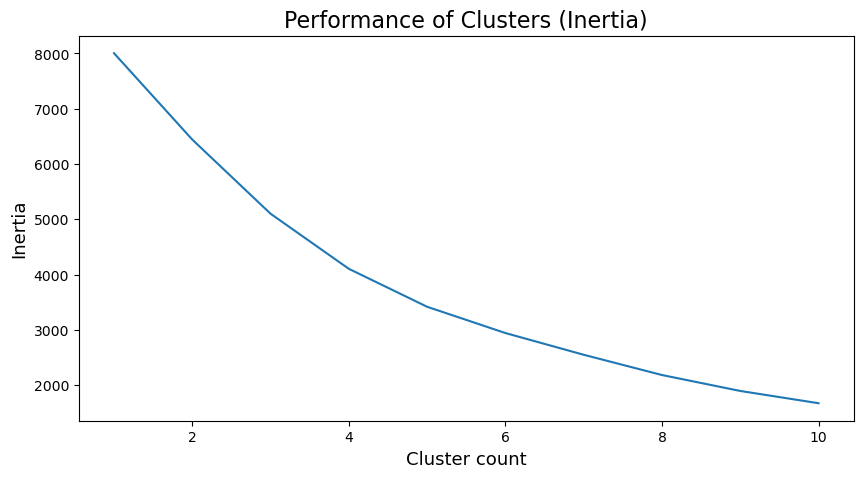

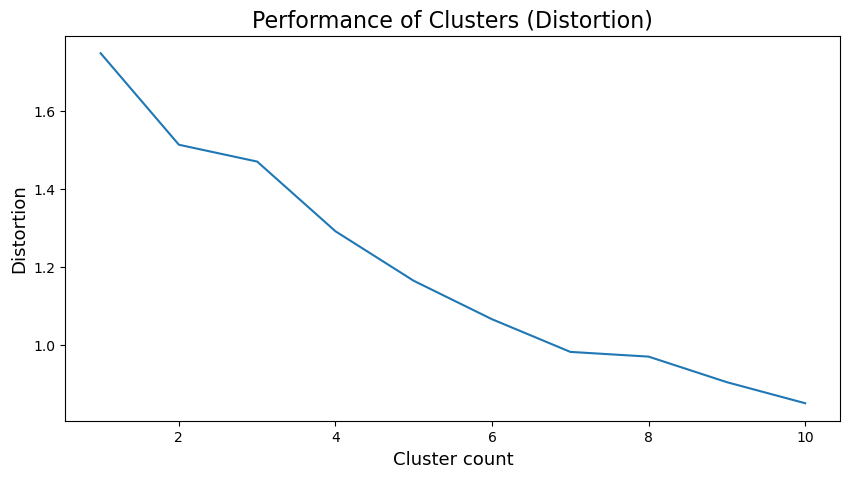

In [243]:
# elbow plot for inertia
plt.figure(figsize=(10,5))
sns.lineplot(data=df2, x='Clusters', y='Inertia')
plt.title('Performance of Clusters (Inertia)', fontsize=16)
plt.xlabel('Cluster count', fontsize=13)
plt.ylabel('Inertia', fontsize=13)
plt.show()

# elbow plot for distortion
plt.figure(figsize=(10,5))
sns.lineplot(data=df2, x='Clusters', y='Distortion')
plt.title('Performance of Clusters (Distortion)', fontsize=16)
plt.xlabel('Cluster count', fontsize=13)
plt.ylabel('Distortion', fontsize=13)
plt.show()

According to the graphs above, the optimal choice of clusters would possibly be at the inflection point of 2 clusters, 3 clusters, or 8 clusters. Now that we know this, first we can check the inertia for each model and recreate the model with the optimal number of clusters.

In [244]:
# fit the model using the optimal number of clusters
model = KMeans(n_clusters=2, random_state=0).fit(X)

# print the inertia for the model and variables used
print('Inertia for the 2-cluster model is : ' + str(model.inertia_))

Inertia for the 2-cluster model is : 6441.944473365456


In [245]:
# fit the model using the optimal number of clusters
model = KMeans(n_clusters=3, random_state=0).fit(X)
# print the inertia for the model and variables used
print('Inertia for the 3-cluster model is : ' + str(model.inertia_))

Inertia for the 3-cluster model is : 5101.236295615849


In [246]:
# fit the model using the optimal number of clusters
model = KMeans(n_clusters=8, random_state=0).fit(X)
# print the inertia for the model and variables used
print('Inertia for the 8-cluster model is : ' + str(model.inertia_))

Inertia for the 8-cluster model is : 2183.968763851609


Ideally, we would've wanted the clustering method to group the data into two groups, one representing the country that has the most threatenend species and the one that has the least threatened species. Unfortunately, since the optimal number of clusters is 8 according to the inertial analyze above, we now have to figure out what each of them represent.

### DBSCAN

We repeat the hyperparameter tuning process used for K-Means, but this time with the silhouette score.

In [247]:
# create list for iterating values and dataframe
clus = []
eps = []
sil = []
for i in [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]:
    model = DBSCAN(eps=i, min_samples=3)
    preds = model.fit_predict(X)
    eps.append(i)
    sil.append(silhouette_score(X, preds))
    clus.append(len(pd.Series(preds).unique()))

# create a data frame with the metrics
df3 = pd.DataFrame({'Clusters': clus, 'Eps': eps, 'Silhouette': sil})
df3

,Clusters,Eps,Silhouette
0,4,1.0,0.331050
1,4,1.1,0.384266
2,5,1.2,0.384927
3,4,1.3,0.385724
4,3,1.4,0.701065
5,3,1.5,0.701065
6,2,1.6,0.809646
7,2,1.7,0.809646
8,2,1.8,0.809646
9,2,1.9,0.827512


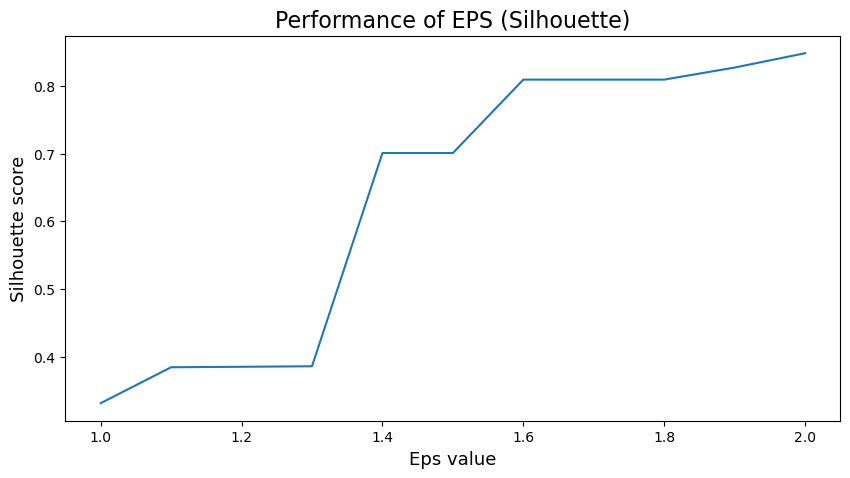

In [248]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df3, x='Eps',y='Silhouette')
plt.title('Performance of EPS (Silhouette)', fontsize=16)
plt.xlabel('Eps value', fontsize=13)
plt.ylabel('Silhouette score', fontsize=13)
plt.show()

The optimal results say that we should choose a DBSCAN model with eps of 2. For context, the eps hyperparameter defines the threshold for distance between points to be considered part of the same cluster. That is, for each point that is being compared to another, if they are less than 2 distance units away from each other, they will be considered as belonging to the same group. For the silhouette score, we want to get as close to 1 as possible, and an eps of 2.0 gave us the highest silhouette score of __0.84__. This score and eps correspond to a model that created __2 clusters__.

In [249]:
# creating the optimal model
model2 = DBSCAN(eps=2, min_samples=3)
preds = model2.fit_predict(X)
# printing their labels and variables used
print('The labels assigned by this model are : ' + str(set(model2.labels_)))

The labels assigned by this model are : {0, -1}


DBSCAN's optimal model clusters the data into 2 groups. This result is closer to what we're looking for, but we need to see whether the clusters correspond to the results we want.

### Hierarchical Clustering

We are going to use Agglomerative method for hierarchical clustering in this section. we will repeat the hyperparameter tuning process used for DBSCAN modeling.

In [250]:
# Perform Agglomerative Clustering
clus = []
sil = []
for i in range(2,11):
    model = AgglomerativeClustering(n_clusters=i)
    preds = model.fit_predict(X)
    sil.append(silhouette_score(X, preds))
    clus.append(i)

# turn the metrics into a dataframe    
df4 = pd.DataFrame({'Clusters': clus, 'Silhouette': sil})
df4

,Clusters,Silhouette
0,2,0.224926
1,3,0.231050
2,4,0.204795
3,5,0.210169
4,6,0.218977
5,7,0.220103
6,8,0.231879
7,9,0.235646
8,10,0.237497


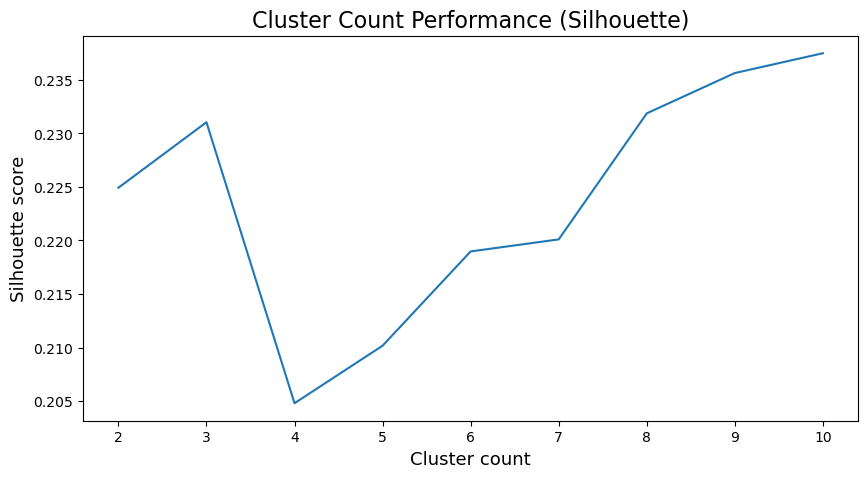

In [251]:
# plot the iterative process
plt.figure(figsize=(10,5))
sns.lineplot(data=df4, x='Clusters',y='Silhouette')
plt.title('Cluster Count Performance (Silhouette)', fontsize=16)
plt.xlabel('Cluster count', fontsize=13)
plt.ylabel('Silhouette score', fontsize=13)
plt.show()

The optimal results say that we should choose a model with 10 clusters, as the silhouette score is highest with that option. However, this sounds to have too many clusters, so if we are interested in minimizing the number of clusters, we can also consider 8 clusters. Since I want the least number of clusters. I will go for 8 clusters. 

In [252]:
# creating the optimal model and finding some of its attributes
model3 = AgglomerativeClustering(n_clusters=3)
preds = model3.fit_predict(X)
# print the labels and variable used in the model
print('The labels assigned by this model are : ' + str(set(model3.labels_)))

The labels assigned by this model are : {0, 1, 2}


Agglomerative clustering's optimal model clusters the data into 3 groups.

I would assume the model will perform the best if the cluster is from 5 to 8. 

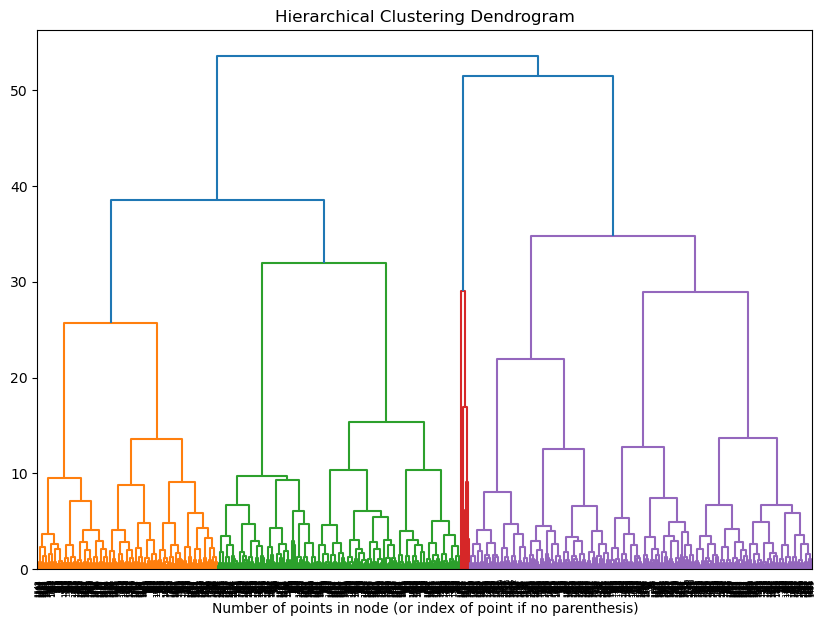

In [253]:
linkage_matrix = linkage(X, method='ward')  # Adjust the method as needed

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.show()

## Text Data
### Feature Selection and Vectorization

Since my record dataset has not provided a satisfying result, I will also perform the same process on my vectorized text data. For the ease of use, I collected a text data for only one topic: 'Climate Change,' using News API. My record dataset is more focused on categorical data, so hopefully the clustering methods will work on the text data. 

After collecting the data using the News API, I used tf-idf vectorizer to convert the text data to numerical data. 

In [254]:

# functions
# function to collect the data
def fetch_article_and_save_to_json(api_key, query, filename = 'articles.json'):
    url = 'https://newsapi.org/v2/everything'
    params = {
      "q": "query",
      "apiKey": api_key,
      "language": "en",
    }
    response = requests.get(url, params = params)
    if response.status_code==200:
        articles_data = response.json()
        
        with open(filename, 'w', encoding = 'utf-8') as f:
            json.dump(articles_data, f, ensure_ascii=False, indent=4)
        return articles_data['articles']
    
    else:
        print(f'Failed to fetch articles: {response.status_code}')
        return None

# function to vectorize the text data into tfidf matrix
def tfidf_vectorize(articles):
    texts = [article['title'] + ' ' + (article['description'] if article['description'] else '') for article in articles]
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

# function for plotting
def plot(X,color_vector):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, cmap="viridis") #, alpha=0.5) #, c=y
    ax.set(xlabel='Feature-1 (x_1)', ylabel='Feature-2 (x_2)',
    title='Cluster data')
    ax.grid()
    plt.show()
    
# functions for hierarchical clustering
def hierarchical_clustering(tfidf_matrix, num_clusters):
    model = AgglomerativeClustering(n_clusters=num_clusters, affinity = 'euclidean', linkage = 'ward')
    model.fit(tfidf_matrix.array())
    return model

def plot_dendrogram(Z, **kwargs):
    counts = np.zeros(Z.children_.shape[0])
    n_samples = len(Z.labels_)
    for i, merge in enumerate(Z.children_):
        current_count = 0
        for idx in merge:
            if idx < n_samples:
                current_count += 1
            else:
                current_count += counts[idx - n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([Z.children_, Z.distances_, counts]).astype(float)
    
    dendrogram(linkage_matrix,**kwargs)
    
import sklearn.cluster

# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH) 
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="kmeans",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X) 

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):

        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            param=0.5*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            model = sklearn.cluster.KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue 

        if(i_print): print(param,sil_scores[-1])
        
        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

In [255]:
articles = fetch_article_and_save_to_json(api_key, 'climate change')
tfidf_matrix = tfidf_vectorize(articles)

clustering_model = AgglomerativeClustering(n_clusters=5, compute_distances=True)
clustering_model = clustering_model.fit(tfidf_matrix.toarray())

dense_tfidf_matrix = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(dense_tfidf_matrix)
tfidf_df['cluster_label'] = clustering_model.labels_
tfidf_df.to_csv('../data/tfidf_matrix_w_clusters.csv', index = False)

tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,1277,1278,1279,1280,1281,1282,1283,1284,1285,cluster_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.201576,0.0,0.16405,0.000000,0.0,0.000000,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.439458,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.175997,0.0,0.000000,0.0,0.0,1
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1


The vectorized text data is as above, which is tfidf matrix and I added another column which indicated the cluster labels. This has 100 records and a lot of columns.

## Model Creation
### K Means

We will go through hyperparameter tuning as we did for the record data. Compared to the record data, we will perform both elbow method and silhouette method to explore the text; tfidf matrix and compare which method is better for the text data. For the elbow method, we want the least value but for the silhouette method, on the other hand, we want to look for the highest value. 

I referred to the lecture and lab assignment codes for this section, so there will be less comments but please refer to the comments above in the record data section, since the process is similar. 

#### Elbow Method

In [256]:
# seperate the dataset into features and labels
x_ = tfidf_df.drop(['cluster_label'], axis=1)
y = tfidf_df[['cluster_label']]

# standardize the data
scaler = StandardScaler()
X_ = scaler.fit_transform(x_)
pd.DataFrame(X_, columns=x_.columns, index=x_.index)

,0,1,2,3,4,5,6,7,8,9,...,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285
0,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.203094,-0.142653,-0.100504,-0.100504,-0.100504,-0.100504
1,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.203094,-0.142653,-0.100504,-0.100504,-0.100504,-0.100504
2,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,9.949874,-0.100504,-0.100504,-0.100504,-0.203094,-0.142653,-0.100504,-0.100504,-0.100504,-0.100504
3,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,9.949874,-0.100504,5.620730,-0.142653,-0.100504,-0.100504,-0.100504,-0.100504
4,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.203094,-0.142653,-0.100504,9.949874,-0.100504,-0.100504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.203094,7.367722,-0.100504,-0.100504,-0.100504,-0.100504
96,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.203094,-0.142653,-0.100504,-0.100504,-0.100504,-0.100504
97,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.203094,-0.142653,-0.100504,-0.100504,-0.100504,-0.100504
98,-0.100504,-0.100504,-0.155034,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.100504,-0.142803,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.203094,-0.142653,-0.100504,-0.100504,-0.100504,-0.100504


In [257]:
model = KMeans(n_clusters=1, random_state=0).fit(X_)
model.cluster_centers_

array([[ 3.44169138e-17, -8.85402862e-17,  5.38458167e-17, ...,
         1.95954364e-16, -1.44328993e-17, -2.63677968e-17]])

In [258]:
distortions = []
inertias = []
k=11

for k in range (1,k):
    kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    kmeanModel.fit(X_)
    distortions.append(sum(np.min(cdist(X_, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X_.shape[0])
    inertias.append(kmeanModel.inertia_)
    evaluation= pd.DataFrame.from_records ({'Cluster':np.arange (1, k+1), 'Distortion' :distortions, 'Inertia':inertias})
evaluation

,Cluster,Distortion,Inertia
0,1,1.762062,128600.000000
1,2,1.736982,126090.904839
2,3,1.714820,124128.695487
3,4,1.698828,123133.039926
4,5,1.678633,121590.702036
5,6,1.671319,118890.910070
6,7,1.635694,117906.559271
7,8,1.611815,115549.026773
8,9,1.590840,113789.946527
9,10,1.560986,110611.922175


array([<Axes: xlabel='Cluster'>, <Axes: xlabel='Cluster'>], dtype=object)

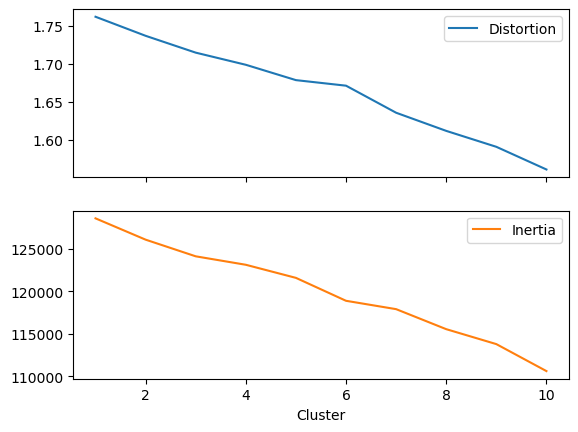

In [259]:
# plot distortion and inertia for kmeans, you can either plot them seperately or use fig, ax = plt.subplots(1, 2) to plot them in the same figure. Suggest the optimal number of clusters based on the plot.
evaluation.plot.line(x = 'Cluster',subplots=True)

According to the graphs above, the optimal choice of clusters would possibly be at the inflection point of 6 clusters. Now that we know this, first we can check the inertia for each model and recreate the model with the optimal number of clusters.

In [260]:
model = KMeans(n_clusters=6, random_state=0).fit(X_)

# print the inertia for the model and variables used
print('Inertia for the 6-cluster model is : ' + str(model.inertia_))

Inertia for the 6-cluster model is : 118927.56650586153


#### Silhouette Method (K Means)

We will perform the silhouette method for K Means and find out which method will give us better results. This time, I used a 'maximize_silhouette' funciton in the lecture.

OPTIMAL PARAMETER = 2


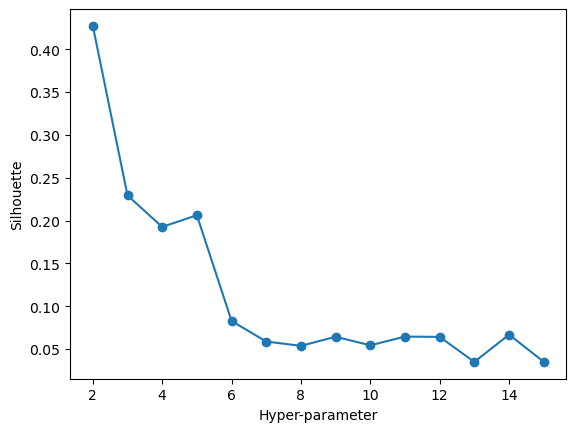

In [261]:
opt_labels=maximize_silhouette(tfidf_df,algo="kmeans",nmax=15, i_plot=True)

According to the graph above, the optimal choice of clusters would be at the inflection point of 2 clusters.

### DBSCAN

We repeat the hyperparameter tuning process used for K-Means, and we will use the silhouette score.

OPTIMAL PARAMETER = 1.5


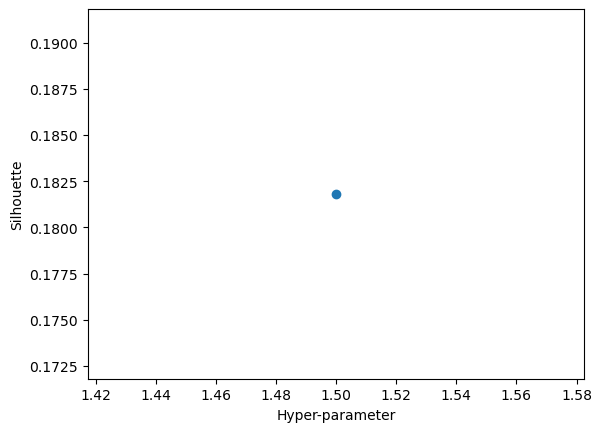

In [262]:
opt_labels=maximize_silhouette(tfidf_df,algo="dbscan",nmax=15, i_plot=True)

As the graph shows, it is clear that the DBSCAN method is not the optimal method for our text data. 

### Hierarchical Clustering

We repeat the hyperparameter tuning process used for DBSCAN modeling.

The dendrogram below is clearly a graph for our text data X, but if we train the data as the code below: 

clustering_model = clustering_model.fit(tfidf_matrix.toarray())

we can get a better result with the number of clusters of 5. 

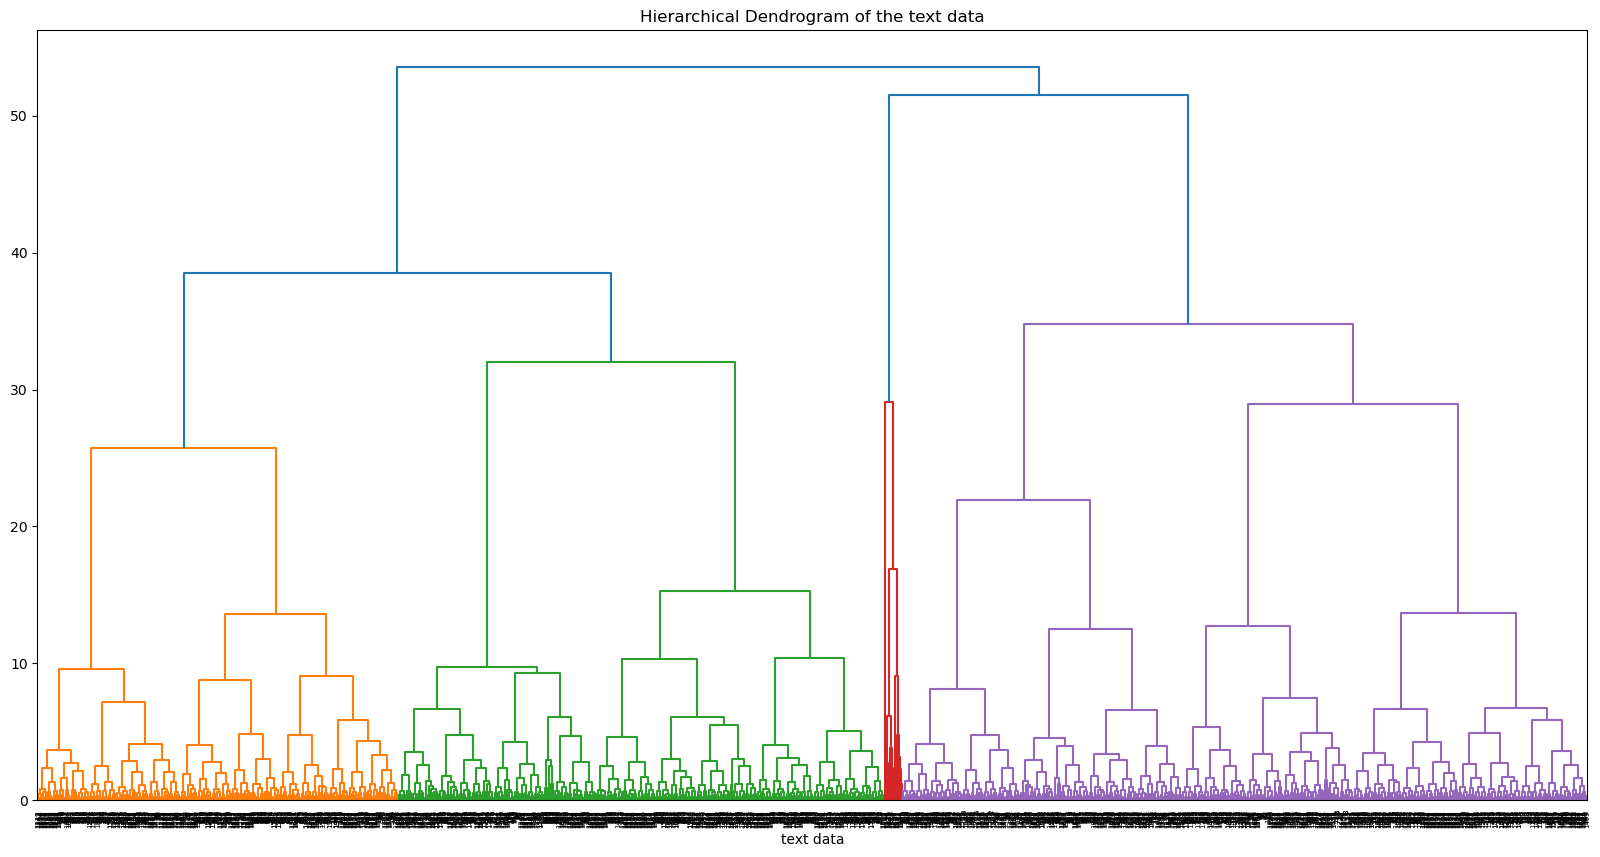

In [263]:
zelda = linkage(X, method='ward')
plt.figure(figsize=(20,10))
plt.title('Hierarchical Dendrogram of the text data')
plt.xlabel("text data")
plot = dendrogram(zelda)

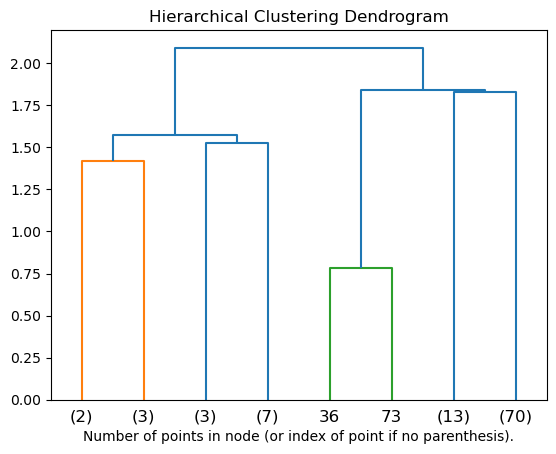

In [264]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering_model, truncate_mode='level', p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Final Results

For my record dataset, I found DBSCAN clustering to be the one that gave the best result, or at least, the results closest to what I was looking for, given that K-Mean works best for linear data. K-Means wanted to create too many clusters: 8 clusters and Hierarchal clustering also wanted to create too much clusters which was 8 to 10. Also, the agglomerative clustering had a lack of accuracy. 

For my text data, it was pretty clear that K-Means method has provided the best result but only for the silhouette method, not the elbow method. Based on the silhouette score, it gave us the result that the optimal number of clusters is 2. The dendrogram was interesting, because hiearchical clustering(agglomerative clustering) provided much better results for the massive tfidf matrix. 

### Record Data

For the record data, DBSCAN was the best method that gave us the optimal number of clusters which is 2 clusters when other methods: KMeans and Hierarchical methods gave us approximately 8 to 10 clusters for the best ones. 

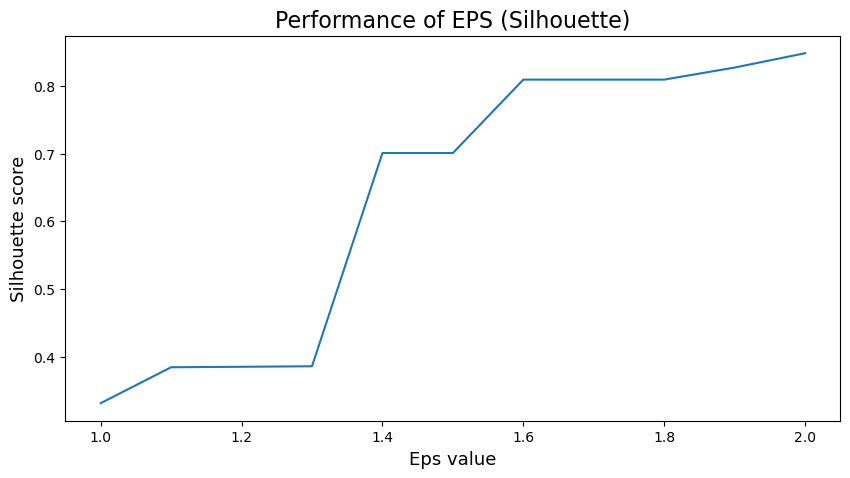

In [265]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df3, x='Eps',y='Silhouette')
plt.title('Performance of EPS (Silhouette)', fontsize=16)
plt.xlabel('Eps value', fontsize=13)
plt.ylabel('Silhouette score', fontsize=13)
plt.show()

### Text Data

For the record data, KMenas was the best method that gave us the optimal number of clusters which is 2 clusters while other methods: DBSCAN was not accurate and Hierarchical clustering gave us 5 clusters for the best ones. 

OPTIMAL PARAMETER = 2


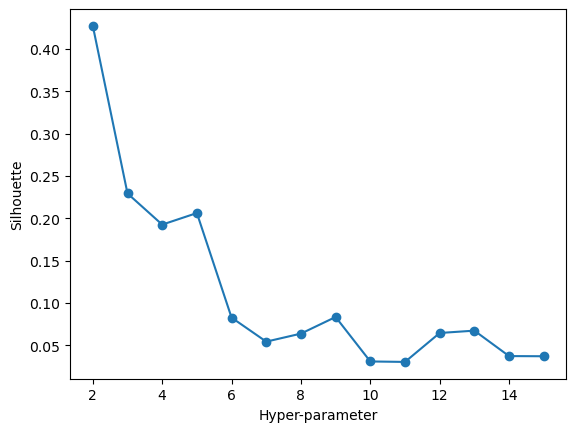

In [267]:
opt_labels=maximize_silhouette(tfidf_df,algo="kmeans",nmax=15, i_plot=True)

## Conclusion
Unfortunately, the clustering did not provide any new insights on the data. The DBSCAN method gets a bit closer to properly separating the clusters than the two other methods for the record data, and KMeans was the most optimal method out of the three methods for the text data, but it's still not good enough. From this limited perspective, I theorize that the variables I have might not be as effective as initially thought. Either that, or some of the variables aren't needed and are just creating additional noise.

I would like to start my conclusion by reminding the reader that clusterization methods are usually employed for exploratory data analysis. These methods are not meant to be used as predictive models, but, with the right data, they can work well in doing so. After using K-Means, DBSCAN, and Agglomerative clustering methods, optimal models separated the data into 2 or 8 clusters. Although the models are likely finding trends in the data we haven't been able to decipher, they aren't keen in clustering the data into only 2 categories.

If desired, we could ask the models to purposely put the data into only two clusters, and then we could compare their label predictions. This would be a next step for this section, but for now I want to accept the recommended optimal models as the ones to analyze.

So instead, as an alternative, I used the MeanShift method below for my record data. Since my text data has too many column, dimensionality reduction is inevitable for this data. So please refer to the dimensionality reduction tab for this. 

Unfortunately, it seems this method cannot provide any further insight for my dataset. 

Number of estimated clusters : 7


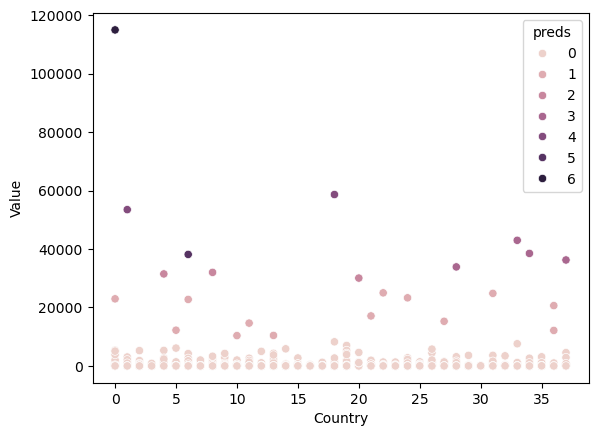

In [268]:
# Perform MeanShift Clustering and predict number 
clusters = MeanShift(bandwidth=2).fit(X)
preds = clusters.predict(X)
print('Number of estimated clusters : ' + str(sum([1 for x in np.unique(preds)])))

x['preds'] = preds
sns.scatterplot(x=x.Country, y=x.Value, hue=x.preds);

Number of estimated clusters : 7


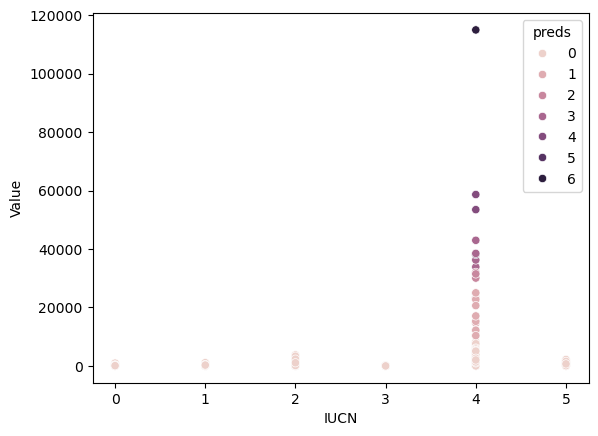

In [269]:
# Perform MeanShift Clustering and predict number 
clusters = MeanShift(bandwidth=2).fit(X)
preds = clusters.predict(X)
print('Number of estimated clusters : ' + str(sum([1 for x in np.unique(preds)])))

x['preds'] = preds
sns.scatterplot(x=x.IUCN, y=x.Value, hue=x.preds);

Number of estimated clusters : 7


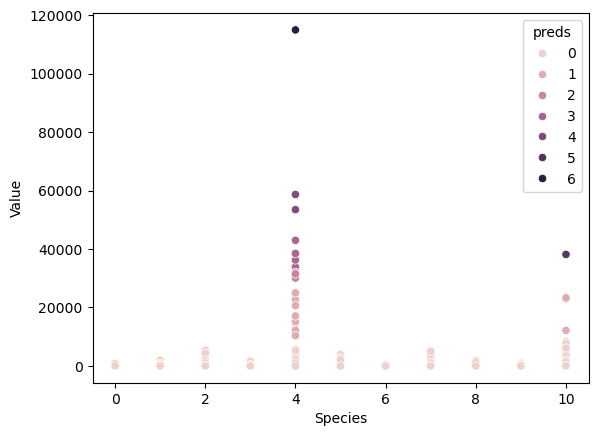

In [271]:
# Perform MeanShift Clustering and predict number 
clusters = MeanShift(bandwidth=2).fit(X)
preds = clusters.predict(X)
print('Number of estimated clusters : ' + str(sum([1 for x in np.unique(preds)])))

x['preds'] = preds
sns.scatterplot(x=x.Species, y=x.Value, hue=x.preds);